# Simon's Algorithm

We are given an unknown blackbox function $f$, which is either one-to-one or two-to-one:

- **one-to-one**: maps exactly one unique output for every input. An example with a function that takes 4 inputs is:

$$f(1) \rightarrow 1, \quad f(2) \rightarrow 2, \quad f(3) \rightarrow 3, \quad f(4) \rightarrow 4$$

- **two-to-one**: maps exactly two inputs to every unique output. An example with a function that takes 4 inputs is:

$$f(1) \rightarrow 1, \quad f(2) \rightarrow 2, \quad f(3) \rightarrow 1, \quad f(4) \rightarrow 2$$

This two-to-one mapping is according to a hidden bitstring, $b$, where:

$$
\textrm{given }x_1,x_2: \quad f(x_1) = f(x_2) \\
\textrm{it is guaranteed }: \quad x_1 \oplus x_2 = b
$$

Given this blackbox $f$, how quickly can we determine if $f$ is one-to-one or two-to-one? Then, if $f$ turns out to be two-to-one, how quickly can we determine $b$? As it turns out, both cases boil down to the same problem of finding $b$, where a bitstring of $b={000...}$ represents the one-to-one $f$.

#### Quantum Solution

Where the query function, $\text{Q}_f$ acts on two quantum registers as:


$$ \lvert x \rangle \lvert a \rangle \rightarrow \lvert x \rangle \lvert a \oplus f(x) \rangle $$

In the specific case that the second register is in the state $|0\rangle = |00\dots0\rangle$ we have:

$$ \lvert x \rangle \lvert 0 \rangle \rightarrow \lvert x \rangle \lvert f(x) \rangle $$

The algorithm involves the following steps.
<ol>
<li> 

The first $n$-qubit input registers are initialized to the $|+\rangle$ state:     
   
$$\lvert \psi_2 \rangle = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0,1\}^{n} } \lvert x \rangle\lvert 0 \rangle^{\otimes n}  $$

</li><li> 

Apply the query function $\text{Q}_f$: 
$$ \lvert \psi_3 \rangle = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0,1\}^{n} } \lvert x \rangle \lvert f(x) \rangle  $$

</li><li> 

Measure the second register where some output $f(x)$ will be observed. Because of the setting of the problem, the observed value $f(x)$ could correspond to two possible inputs: $x$ and $y = x \oplus b $. Therefore the first register becomes:
$$\lvert \psi_4 \rangle = \frac{1}{\sqrt{2}}  \left( \lvert x \rangle + \lvert y \rangle \right)$$

where we omitted the second register since it has been measured. 
</li>   
<li> Apply Hadamard on the first register:
   

$$ \lvert \psi_5 \rangle = \frac{1}{\sqrt{2^{n+1}}} \sum_{z \in \{0,1\}^{n} } \left[  (-1)^{x \cdot z} + (-1)^{y \cdot z} \right]  \lvert z \rangle  $$


</li>
<li> Measuring the first register will give an output only if:
   
$$ (-1)^{x \cdot z} = (-1)^{y \cdot z} $$
which means:
$$ 
x \cdot z = y \cdot z \\
   x \cdot z = \left( x \oplus b \right) \cdot z \\
   x \cdot z = x \cdot z \oplus b \cdot z \\
b \cdot z = 0 \text{ (mod 2)} 
$$
   
A string $z$ will be measured, whose inner product with $b = 0$. Thus, repeating the algorithm $\approx n$ times, we will be able to obtain $n$ different values of $z$ and the following system of equation can be written:
      

$$ \begin{cases} b \cdot z_1 = 0 \\ b \cdot z_2 = 0 \\ \quad \vdots \\ b \cdot z_n = 0 \end{cases}$$
      
From which $b$ can be determined, for example by Gaussian elimination.
</li>
</ol>

So, in this particular problem the quantum algorithm performs exponentially fewer steps than the classical one. Once again, it might be difficult to envision an application of this algorithm (although it inspired the most famous algorithm created by Shor) but it represents the first proof that there can be an exponential speed-up in solving a specific problem by using a quantum computer rather than a classical one.

## 3. Qiskit Implementation

In [2]:
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit

In [12]:
def simon_oracle(b):
    """returns a Simon oracle for bitstring b"""
    b = b[::-1] # reverse b for easy iteration
    n = len(b)
    qc = QuantumCircuit(n*2)
    # Do copy; |x>|0> -> |x>|x>
    for q in range(n):
        qc.cx(q, q+n)
    if '1' not in b:
        return qc  # 1:1 mapping, so just exit
    i = b.find('1') # index of first non-zero bit in b
    # Do |x> -> |s.x> on condition that q_i is 1
    for q in range(n):
        if b[q] == '1':
            qc.cx(i, (q)+n)
    return qc

In [19]:
b = '110'

n = len(b)
simon_circuit = QuantumCircuit(n*2, n)

simon_circuit.h(range(n))
simon_circuit.barrier()

simon_circuit.append(simon_oracle(b), range(n*2))
simon_circuit = simon_circuit.decompose()
simon_circuit.barrier()

simon_circuit.h(range(n))
simon_circuit.measure(range(n), range(n))
simon_circuit.draw()

┌─────────┐ ░                           ░ ┌───┐┌─┐      
q_0: ┤ U2(0,π) ├─░───■───────────────────────░─┤ H ├┤M├──────
     ├─────────┤ ░   │                       ░ ├───┤└╥┘┌─┐   
q_1: ┤ U2(0,π) ├─░───┼────■─────────■────■───░─┤ H ├─╫─┤M├───
     ├─────────┤ ░   │    │         │    │   ░ ├───┤ ║ └╥┘┌─┐
q_2: ┤ U2(0,π) ├─░───┼────┼────■────┼────┼───░─┤ H ├─╫──╫─┤M├
     └─────────┘ ░ ┌─┴─┐  │    │    │    │   ░ └───┘ ║  ║ └╥┘
q_3: ────────────░─┤ X ├──┼────┼────┼────┼───░───────╫──╫──╫─
                 ░ └───┘┌─┴─┐  │  ┌─┴─┐  │   ░       ║  ║  ║ 
q_4: ────────────░──────┤ X ├──┼──┤ X ├──┼───░───────╫──╫──╫─
                 ░      └───┘┌─┴─┐└───┘┌─┴─┐ ░       ║  ║  ║ 
q_5: ────────────░───────────┤ X ├─────┤ X ├─░───────╫──╫──╫─
                 ░           └───┘     └───┘ ░       ║  ║  ║ 
c: 3/════════════════════════════════════════════════╩══╩══╩═
                                                     0  1  2

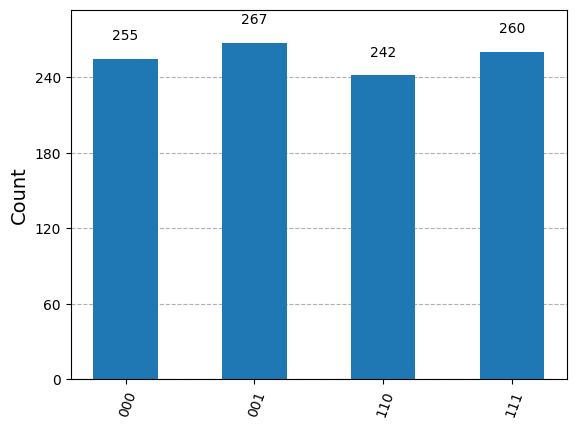

In [20]:
# use local simulator
aer_sim = AerSimulator()
shots = 1024
results = aer_sim.run(simon_circuit).result()
counts = results.get_counts()
plot_histogram(counts)

Since we know $b$ already, we can verify these results do satisfy $b\cdot z  = 0 \pmod{2}$:

In [21]:
# Calculate the dot product of the results
def bdotz(b, z):
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return (accum % 2)

for z in counts:
    print( '{}.{} = {} (mod 2)'.format(b, z, bdotz(b,z)) )

110.111 = 0 (mod 2)
110.001 = 0 (mod 2)
110.110 = 0 (mod 2)
110.000 = 0 (mod 2)


Using these results, we can recover the value of $b = 110$ by solving this set of simultaneous equations. For example, say we first measured `001`, this tells us:

$$
\begin{aligned}
b \cdot 001 &= 0 \\
(b_2 \cdot 0) + (b_1 \cdot 0) + (b_0 \cdot 1) & = 0 \\
(\cancel{b_2 \cdot 0}) + (\cancel{b_1 \cdot 0}) + (b_0 \cdot 1) & = 0 \\
b_0 & = 0\\
\end{aligned}
$$

If we next measured `111`, we have:

$$
\begin{aligned}
b \cdot 111 &= 0 \\
(b_2 \cdot 1) + (b_1 \cdot 1) + (\cancel{0 \cdot 1}) & = 0 \\
(b_2 \cdot 1) + (b_1 \cdot 1) & = 0 \\
\end{aligned}
$$

Which tells us either:

$$ 
b_2 = b_1 = 0, \quad b = 000 
$$

or 

$$ 
b_2 = b_1 = 1, \quad b = 110 
$$

Of which $b  = 110$ is the non-trivial solution to our simultaneous equations. We can solve these problems in general using Gaussian elimination, which has a run time of $O(n^3)$.